# STA 208: Homework 4
This is based on the material in Chapters 5,6 of 'Elements of Statistical Learning' (ESL), in addition to lectures 10-13.

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements (beginning with __Exercise X.X__).  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

In the conceptual exercises you should provide an explanation, with math when necessary, for any answers.  When answering with math you should use basic LaTeX, as in 
$$E(Y|X=x) = \int_{\mathcal{Y}} f_{Y|X}(y|x) dy = \int_{\mathcal{Y}} \frac{f_{Y,X}(y,x)}{f_{X}(x)} dy$$
for displayed equations, and $R_{i,j} = 2^{-|i-j|}$ for inline equations.  (To see the contents of this cell in markdown, double click on it or hit Enter in escape mode.)  To see a list of latex math symbols see here: http://web.ift.uib.no/Teori/KURS/WRK/TeX/symALL.html

When writing pseudocode, you should use enumerated lists, such as 

__Algorithm: Ordinary Least Squares Fit__
(Input: X, y; 
Output: $\beta$)
1. Initialize the $p \times p$ Gram matrix, $G \gets 0$, and the vector $b \gets 0$.
2. For each sample, $x_i$:
 1. $G \gets G + x_i x_i^\top$.
 2. $b \gets b + y_i x_i$
3. Solve the linear system $G \beta = b$ and return $\beta$


## Transfusion dataset
Read in the transfusion data using the code below.

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as agcluster
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster._hierarchical import compute_ward_dist
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [69]:
Dtrans = np.loadtxt("transfusion.data",dtype=np.str_,delimiter=",")
X = np.array(Dtrans[1:,0:4],dtype=float)
y = np.array(Dtrans[1:,4],dtype=float)
X = scale(X)

__Exercise 1.1__ (10 pts) Use 5-fold cross validation, leave-one-out CV, and a 50% holdout to tune the bandwidth and ridge penalty parameter for the RBF kernel for SVMs.  Qualitatively compare the results.

In [70]:
#50% holdout
cv1 = 2
#5-fold CV
cv2 = KFold(n_splits = 5)
#LOO CV
cv3 = LeaveOneOut()

def best_params(cv, X, y, kernel):
    C_range = [0.001, 0.01, 0.1, 1, 10]
    gamma_range = [0.001, 0.01, 0.1, 1]
    param_grid = dict(gamma=gamma_range, C=C_range)
    grid = GridSearchCV(SVC(kernel=kernel), param_grid=param_grid, cv=cv)
    grid.fit(X, y)

    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))


In [36]:
best_params(cv1, X, y, 'rbf')

The best parameters are {'C': 1, 'gamma': 1} with a score of 0.79


In [37]:
best_params(cv2, X, y, 'rbf')

The best parameters are {'C': 1, 'gamma': 1} with a score of 0.79


In [38]:
best_params(cv3, X, y, 'rbf')

The best parameters are {'C': 1, 'gamma': 1} with a score of 0.79


We find that the best parameters for all types of CV are C = 1 and gamma = 1. All give a score of 0.79. 

__Exercise 1.2__ (10 pts) Select one of these methods for tuning the bandwidth parameters and make this a function that takes in a dataset, performs cross-validation, and outputs the tuning parameters.  Make a training and test set split and tune parameters for linear SVMs, RBF kernel SVMs, and logistic regression on the training set, then compare their performances on the test set using ROC and PR curves.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [42]:
best_params(cv2, X_train, y_train, 'linear')

The best parameters are {'C': 0.001, 'gamma': 0.001} with a score of 0.78


In [43]:
best_params(cv2, X_train, y_train, 'rbf')

The best parameters are {'C': 10, 'gamma': 0.1} with a score of 0.79


In [9]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(LogisticRegression(penalty = 'l2'), param_grid=param_grid, cv=cv2)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.01} with a score of 0.78


In [12]:
clf = LogisticRegression(C = 0.1, penalty = 'l2') #use Newton conjugate gradient#
clf.fit(X_train,y_train)
prob1 = clf.predict_proba(X_test)
y_score1 = clf.fit(X_train, y_train).decision_function(X_test)
fpr1, tpr1, roc_thresholds1 = roc_curve(y_test, y_score1) 
precision1, recall1, thresholds1 = precision_recall_curve(y_test, y_score1)

In [14]:
svm1 = SVC(C = 0.001, gamma = 0.001, kernel = 'linear', probability=True)
svm1.fit(X_train, y_train)
prob2 = svm1.predict_proba(X_test)
y_score2 = svm1.fit(X_train, y_train).decision_function(X_test)
fpr2, tpr2, roc_thresholds2 = roc_curve(y_test, y_score2)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_score2)

In [15]:
svm2 = SVC(C = 10, gamma = 0.1, kernel = 'rbf', probability=True)
svm2.fit(X_train, y_train)
prob3 = svm2.predict_proba(X_test)
y_score3 = svm2.fit(X_train, y_train).decision_function(X_test)
fpr3, tpr3, roc_thresholds3 = roc_curve(y_test, y_score3)
precision3, recall3, thresholds3 = precision_recall_curve(y_test, y_score3)

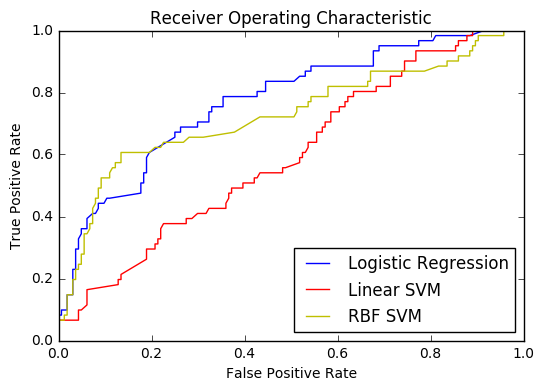

In [16]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1,tpr1,'b-',label='Logistic Regression')
plt.plot(fpr2,tpr2,'r-',label='Linear SVM')
plt.plot(fpr3,tpr3,'y-',label='RBF SVM')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

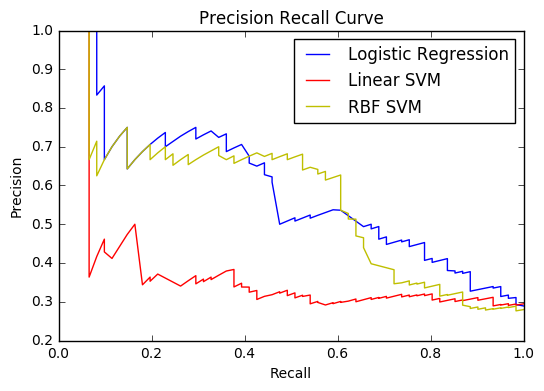

In [17]:
plt.title('Precision Recall Curve')
plt.plot(recall1,precision1,'b-',label='Logistic Regression')
plt.plot(recall2,precision2,'r-',label='Linear SVM')
plt.plot(recall3,precision3,'y-',label='RBF SVM')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='best')
plt.show()

We can see that logistic regression perfoms best and linear SVM performs the worst. 

## Reuters dataset
The following dataset contains stemmed words from the Reuters dataset, which is articles.  Each line starts with a topic label (of 8 topics) and then has all of the terms in the document.

In [14]:
from collections import Counter
import scipy.sparse as sp
import pandas as pd

In [3]:
def read_corpus(filename):
    """
    Read a R8 corpus
    Input: filename
    Output: the corpus which is a list of documents with topic labels and stemmed terms
    """
    corpus = []
    DF = Counter()
    with open(filename,"r") as f:
        for line in f:
            label, terms = line.split('\t')
            terms = terms.strip().split()
            label = label.strip()
            corpus.append([label,Counter(terms)])
            DF += Counter(set(terms))
    return(corpus, DF)

In [4]:
train_corpus, train_DF = read_corpus('r8-train-stemmed.txt')
test_corpus, test_DF = read_corpus('r8-test-stemmed.txt')

In [5]:
# You should use the document frequency for the whole corpus
full_DF = train_DF + test_DF

In [6]:
## dict_list is the list of dictionary terms, 
## while dict_index can take you from the term back to its index
dict_list = full_DF.keys()
dict_index = {t:i for i,t in enumerate(dict_list)}

In [7]:
n, p = len(train_corpus), len(full_DF)
logN = np.log(len(train_corpus) + len(test_corpus))

In [8]:
X_tr = sp.lil_matrix((n,p))

In [9]:
## This creates the sparse training matrix, you will need to modify this to create the test matrix.
## I am using a normalized TFIDF transform below, figure out what it is doing.
for i in xrange(n):
    tpc, doc = train_corpus[i]
    vec = np.array([(logN - np.log(train_DF[term]))*doc[term] for term in doc.keys()])
    vec = vec / np.linalg.norm(vec)
    X_tr[i,[dict_index[term] for term in doc.keys()]] = vec

__Exercise 2.1__ (10 pts) Compute Kmeans with 8 clusters on the training set.  For each cluster, what are the 10 terms that have the highest components in the cluster center vectors?  What are the sizes of the clusters?  Compute a 'confusion matrix' to compare these 8 clusters to the labelled topics (I want an 8 x 8 matrix of counts of documents in each topic and cluster - there are 8 topics).

In [18]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X_tr)

In [19]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [25]:
top10 = {}
for i in xrange(8):
    top10[i] = centers[i].argsort()[-11:][::-1]

In [26]:
terms_top10 = {}
for i in xrange(8):
    terms = []
    for term, ix, in dict_index.items():
        if ix in top10[i]:
            terms.append(term)
    terms_top10[i] = terms

In [27]:
pd.DataFrame(terms_top10)

,0,1,2,3,4,5,6,7
0,for,prime,franc,oper,oper,oper,prior,opec
1,offer,custom,mln,mln,note,mln,set,trade
2,compani,bank,pretax,qtr,mln,qtr,dividend,offici
3,mln,rais,bank,ct,qtr,ct,ct,japan
4,inc,rate,market,year,ct,year,payout,that
5,pct,pct,stg,shr,year,shr,march,import
6,stock,bill,net,loss,shr,loss,april,oil
7,share,cut,billion,net,net,net,div,japanes
8,and,dai,monei,rev,rev,rev,pai,and
9,will,repurchas,tax,profit,dlr,dlr,qtly,minist


The above is the top 10 terms with the highest components in the cluster centers. 

In [28]:
Counter(labels)

Counter({0: 2651, 1: 286, 2: 233, 3: 361, 4: 707, 5: 281, 6: 468, 7: 498})

In [29]:
ypred = pd.Series(labels).value_counts()
ypred

0    2651
4     707
7     498
6     468
3     361
1     286
5     281
2     233
dtype: int64

Above are the sizes of the clusters. 

In [30]:
ytrue = pd.DataFrame(train_corpus)[0].value_counts()
ytrue

earn        2840
acq         1596
crude        253
trade        251
money-fx     206
interest     190
ship         108
grain         41
Name: 0, dtype: int64

In [47]:
doc_labels = pd.DataFrame(train_corpus)[0].values
doc_labels_code = {'earn': 0, 'acq': 1, 'crude': 2, 'trade': 3, 'money-fx': 4,
                  'interest':5, 'ship':6, 'grain':7}
term_labels = [doc_labels_code[label] for label in doc_labels]
print confusion_matrix(term_labels, labels)

[[ 833   30  158  361  707  281  468    2]
 [1551   21    1    0    0    0    0   23]
 [ 103    0    1    0    0    0    0  149]
 [   4    0   16    0    0    0    0  231]
 [  19   61   56    0    0    0    0   70]
 [   7  174    1    0    0    0    0    8]
 [ 103    0    0    0    0    0    0    5]
 [  31    0    0    0    0    0    0   10]]


Above is the confusion matrix. We can't recover the words of the cluster centers, so we don't know if they are the same as the 8 topics. 

__Exercise 2.2__ (10 pts) Reverse the roles of words and documents and perform hierarchical agglomerative clustering (you can just transpose X) up to 40 clusters.  Compare the dendrograms for three different linkage types, and try to make sense of the resulting clusters.

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [56]:
common1000 = train_DF.most_common(1000)
common_words = [pair[0] for pair in common1000]
X_train_common1000 = sp.lil_matrix((n, 1000))

In [57]:
for i in xrange(n):
    tpc, doc = train_corpus[i]
    if doc in common_words:
            vec = np.array([(logN - np.log(train_DF[term]))*doc[term] for term in doc.keys()])
            vec = vec / np.linalg.norm(vec)
            X_train_common1000[i,[dict_index[term] for term in doc.keys()]] = vec

In [58]:
X = X_train_common1000.toarray().T

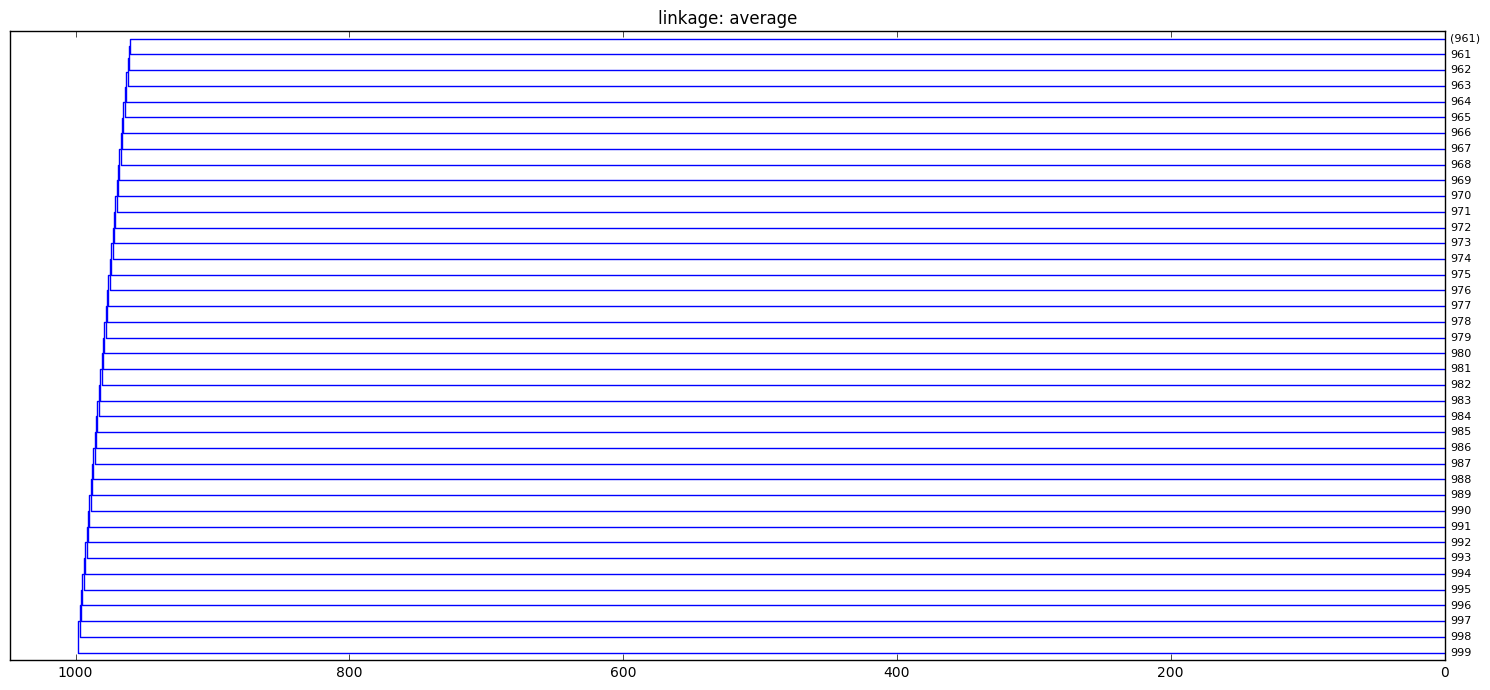

In [59]:
model = agcluster(n_clusters=40, affinity='euclidean', linkage='average').fit(X)
distance = np.arange(model.children_.shape[0])
position = np.arange(2, model.children_.shape[0]+2)

linkage_matrix = np.column_stack([
            model.children_, distance, position]
        ).astype(float)
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(linkage_matrix, orientation='left', p = 40,
    truncate_mode = 'lastp',)
plt.tick_params(axis='x')
plt.title('linkage: average')
plt.tight_layout()
plt.show()

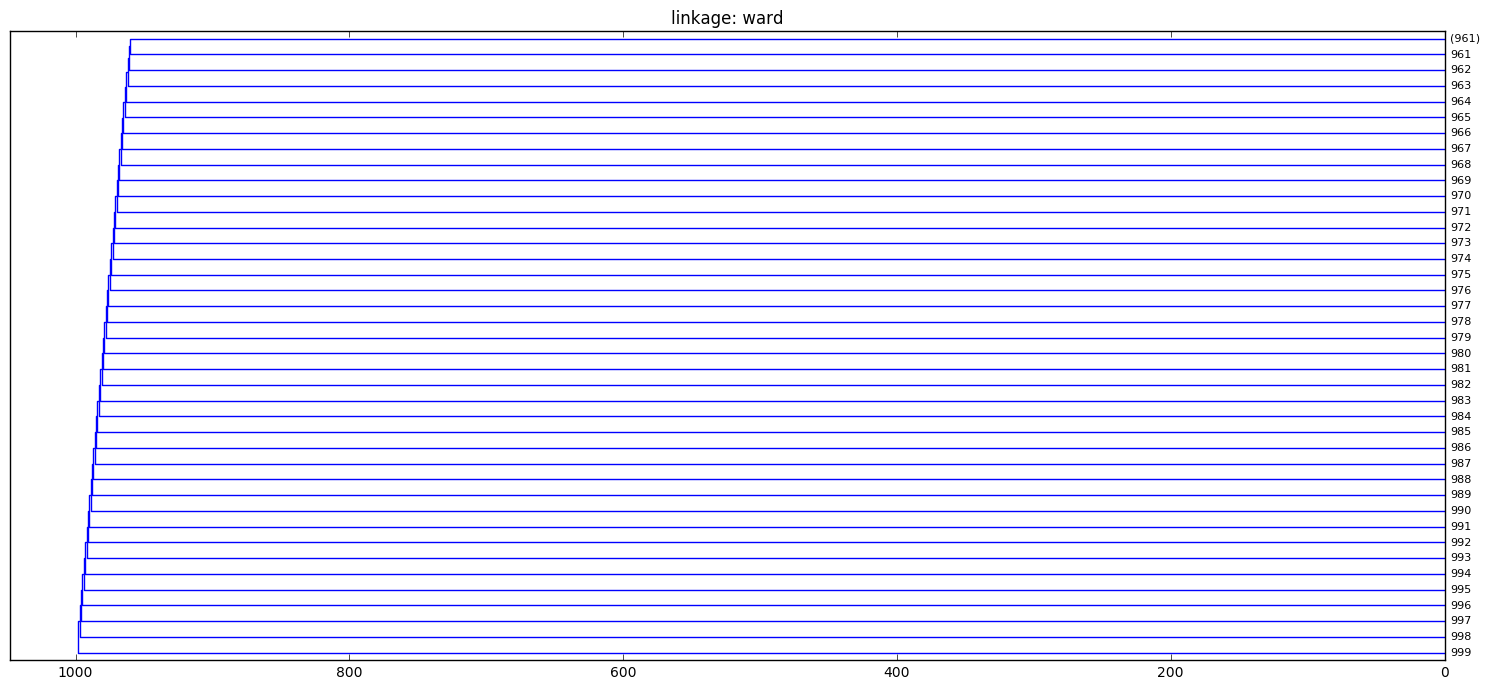

In [60]:
model2 = agcluster(n_clusters=40, affinity='euclidean', linkage='ward').fit(X)
distance = np.arange(model2.children_.shape[0])
position = np.arange(2, model2.children_.shape[0]+2)

linkage_matrix = np.column_stack([
            model2.children_, distance, position]
        ).astype(float)
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(linkage_matrix, orientation='left', p = 40,
    truncate_mode = 'lastp',)
plt.tick_params(axis='x')
plt.title('linkage: ward')
plt.tight_layout()
plt.show()

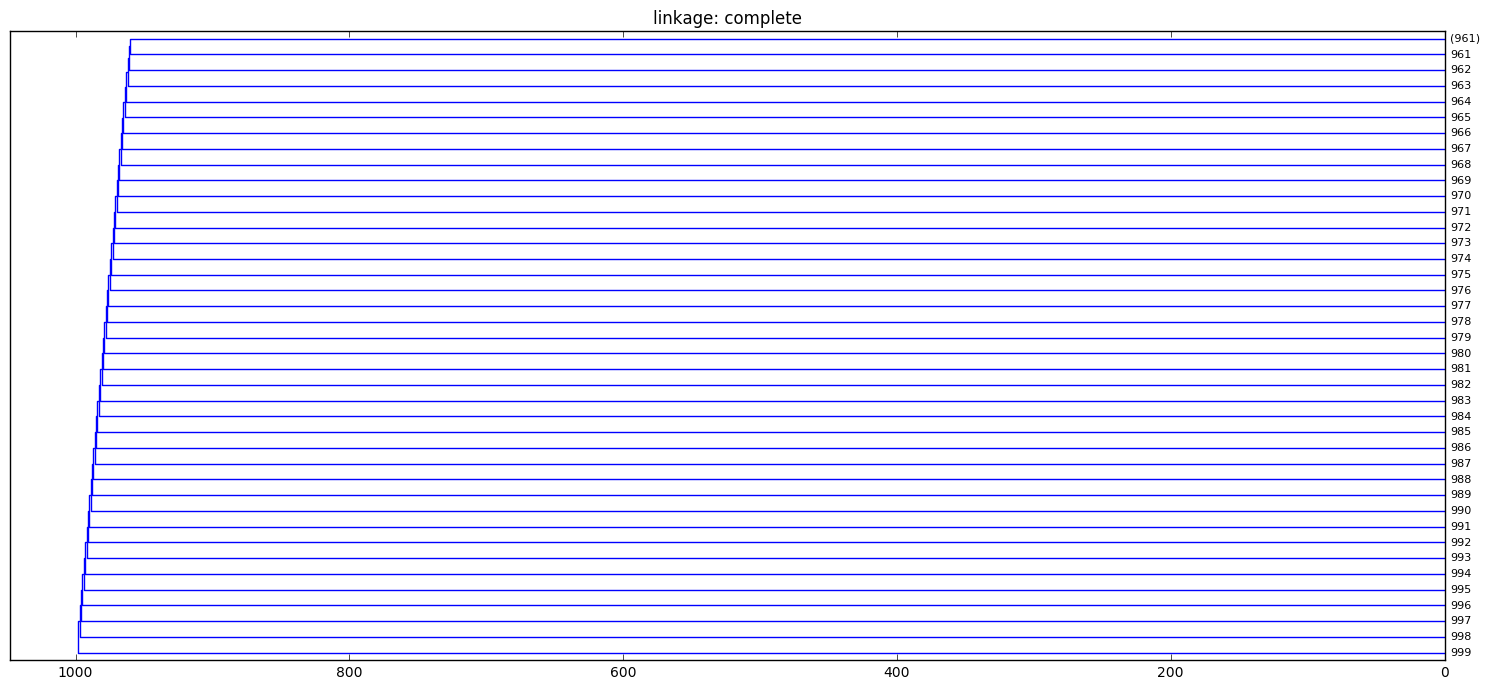

In [61]:
model3 = agcluster(n_clusters=40, affinity='euclidean', linkage='complete').fit(X)
distance = np.arange(model3.children_.shape[0])
position = np.arange(2, model3.children_.shape[0]+2)

linkage_matrix = np.column_stack([
            model2.children_, distance, position]
        ).astype(float)
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(linkage_matrix, orientation='left', p = 40,
    truncate_mode = 'lastp',)
plt.tick_params(axis='x')
plt.title('linkage: complete')
plt.tight_layout()
plt.show()

We are getting the same clustering for the 3 different linkage types, but I am not sure why. 

__Exercise 2.3__ (10 pts) Use SVMs trained on the training set to predict the test set.  Evaluate the performance with the ROC, PR, and confusion matrix.  Don't forget to appropriately cross-validate to tune parameters.

In [76]:
best_params(cv2, X_tr, y, 'linear')

The best parameters are {'C': 10, 'gamma': 0.001} with a score of 0.96


In [77]:
best_params(cv2, X_tr, y, 'rbf')

The best parameters are {'C': 10, 'gamma': 0.1} with a score of 0.96


In [78]:
n = len(test_corpus)
X_test = sp.lil_matrix((n, p))
for i in xrange(n):
    tpc, doc = test_corpus[i]
    vec = np.array([(logN - np.log(test_DF[term]))*doc[term] for term in doc.keys()])
    vec = vec / np.linalg.norm(vec)
    X_test[i,[dict_index[term] for term in doc.keys()]] = vec

In [81]:
y_actual = [doc[0] for doc in test_corpus]
print np.unique(y_actual)
names = ['acq', 'crude', 'earn', 'grain', 'interest', 'money-fx', 'ship',
       'trade']
y_test = label_binarize(y_actual, classes=names)

['acq' 'crude' 'earn' 'grain' 'interest' 'money-fx' 'ship' 'trade']


In [82]:
y_pred = svm_detector.predict(X_test)

In [83]:
print 'Confusion Matrix'
print confusion_matrix(y_actual, y_pred)
print ''
print 'Classification report'
print classification_report(y_actual, y_pred)

Confusion Matrix
[[ 681    1   12    0    0    0    0    2]
 [   5  113    0    0    0    0    2    1]
 [   6    0 1077    0    0    0    0    0]
 [   0    0    0   10    0    0    0    0]
 [   2    0    0    0   68   10    0    1]
 [   5    0    1    0    6   73    0    2]
 [   6    3    0    0    0    0   27    0]
 [   2    0    0    0    0    0    0   73]]

Classification report
             precision    recall  f1-score   support

        acq       0.96      0.98      0.97       696
      crude       0.97      0.93      0.95       121
       earn       0.99      0.99      0.99      1083
      grain       1.00      1.00      1.00        10
   interest       0.92      0.84      0.88        81
   money-fx       0.88      0.84      0.86        87
       ship       0.93      0.75      0.83        36
      trade       0.92      0.97      0.95        75

avg / total       0.97      0.97      0.97      2189



In [86]:
classifier = OneVsRestClassifier(SVC(C = 10, kernel='linear', probability=True))

In [87]:
y_score = classifier.fit(X_tr, y).decision_function(X_test)

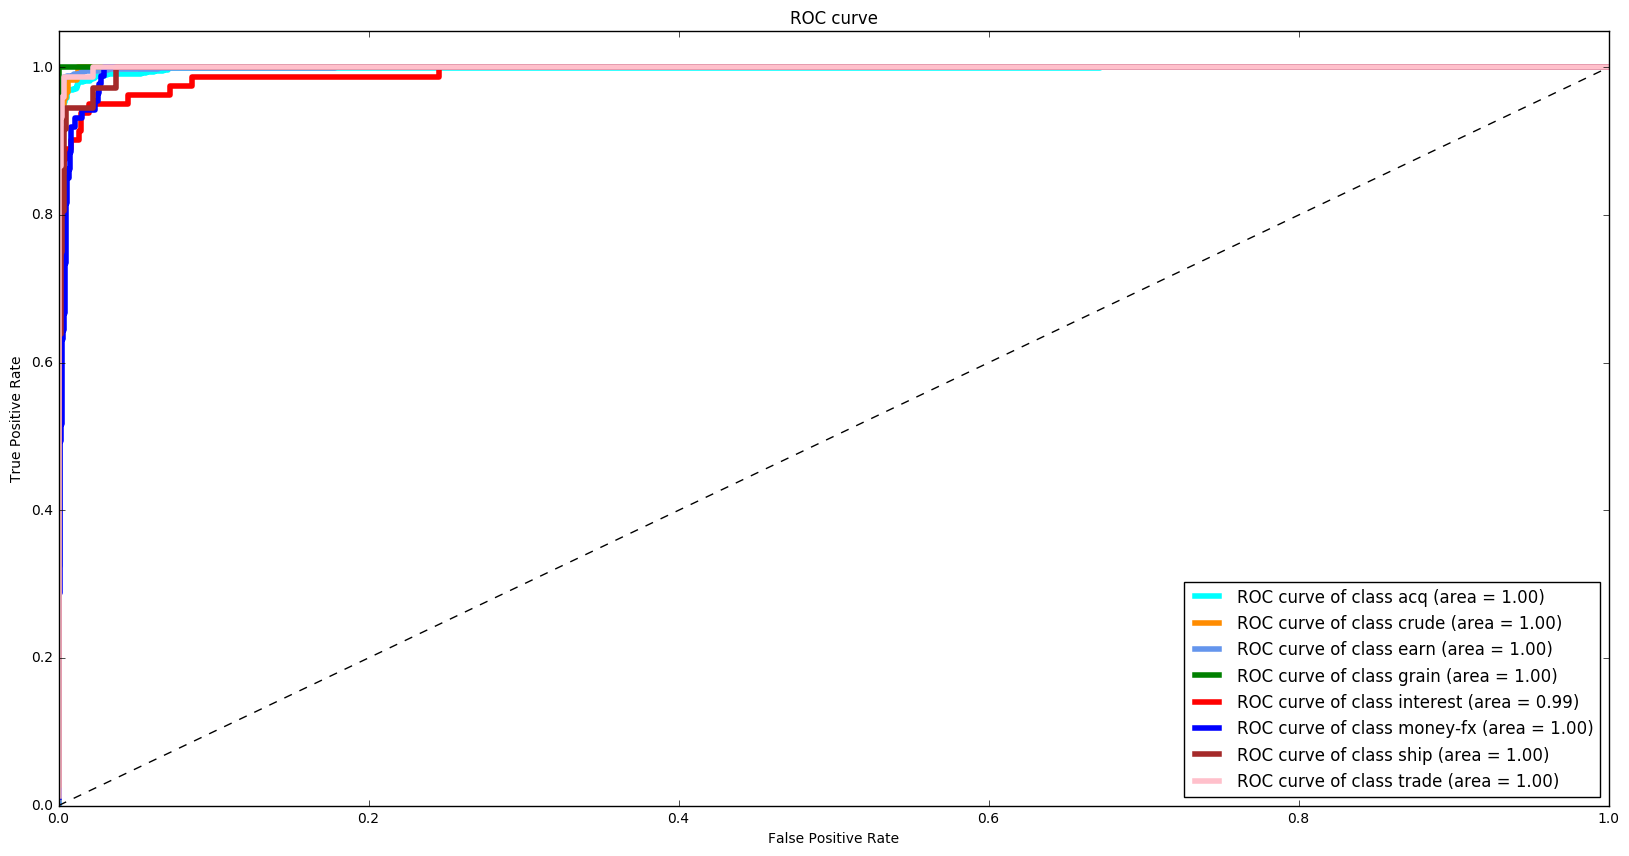

In [90]:
n_classes = 8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curves
lw = 4
plt.figure(figsize=(20,10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'blue', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

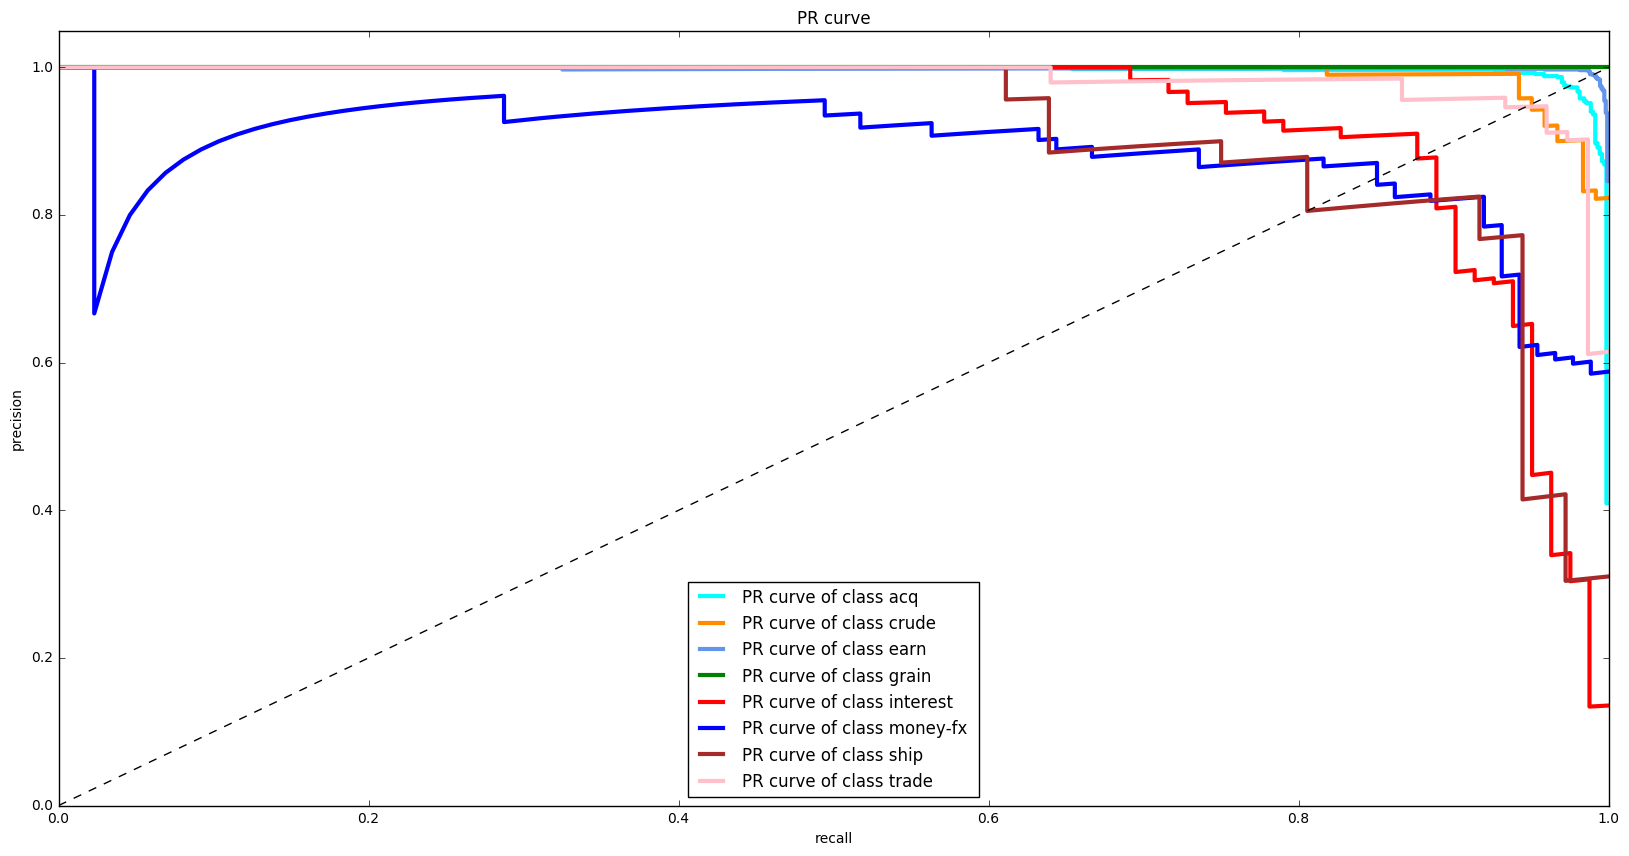

In [91]:
precision = dict()
recall = dict()
for i in xrange(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

# Plot all ROC curves
lw = 3
plt.figure(figsize = (20, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'blue', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='PR curve of class {0} '.format(names[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PR curve')
plt.legend(loc="best")
plt.show()

After tuning the parameters with 5 fold CV, we find that C = 10 is the best parameter. Since the linear and rbf kernels have the same score with C = 10, we choose one, say linear. Overall, the model does very well in predicting the test set. Some classes were predicted more accurately than others, but overall the ROC and PR curves show strong performance. 